<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_5_2_Ensemble_of_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 5.2 Ансамбли деревьев решений

## Случайный лес, Адаптивный бустинг, Градиентный бустинг, Изолирующий лес

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Интерактивное дерево решений (Олег Мельников, 2021)

In [ ]:
%reset -f
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from ipywidgets import interactive, interact, HBox, Layout, VBox

rng = np.random.RandomState(0)      # seed the state (an alias for seeded np.random)
X = 10 * rng.rand(200, 1)           # train values of the 1D feature X
Y = np.sin(X).ravel() + .5*rng.normal(size=len(X)) # add white noise to 10% of sin() values
tX, vX, tY, vY = train_test_split(X, Y, test_size=.4, random_state=0)

In [ ]:
def ShowTree(depth=1, leafSize=1, nLeaves=100):
  dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leafSize, max_leaf_nodes=nLeaves, random_state=0).fit(tX, tY)
  pY = dt.predict(vX)
  nLeaf = (pd.DataFrame(dt.tree_.__getstate__()['nodes']).left_child==-1).sum() # leaves do not have children in the table of nodes
  print(f'Train R^2={dt.score(tX, tY):.3}; Test R^2={dt.score(vX, vY):.3}; Depth={dt.get_depth()}; Nodes={dt.tree_.node_count}; Leaves={nLeaf}')

  df = pd.DataFrame(dict(tX=tX.ravel(), tY=tY))
  _, ax = plt.subplots(ncols=2, figsize=(30, 2 + dt.get_depth()), gridspec_kw={'width_ratios': [1, 3]})
  ax1 = df.plot.scatter('tX', 'tY', grid=True, color='b', label="train case", ax=ax[0], title='DT fitted to sine + Noise');
  pd.DataFrame(pY, index=vX.ravel(), columns=['pY (tree function)']).sort_index().plot(color='b', label="fitted tree", drawstyle="steps", ax=ax1);
  ax[0].scatter(vX, vY, color='red', label="test case");
  ax[0].legend();
  plot_tree(dt, filled=True, proportion=True, rounded=True, precision=2, fontsize=10, feature_names=['X'], ax=ax[1]);
  plt.tight_layout();

widget = interactive(ShowTree, depth=(1, 20), leafSize=(1,10), nLeaves=(5,100,5)) # draw sliders
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))      # place sliders horizontally
display(VBox([controls, widget.children[-1]]))
widget.update()

Адаптивный бустинг
----------------

**Бустинг** - одна из самых полезных идей обучения, появившихся за последние двадцать лет. Давайте опишем теорию, лежащую в ее основе, и начнем с первой модели, *AdaBoost*.

Рассмотрим задачу бинарной классификации, выходной переменной которой является $y \in \{-1, 1\}$, и мы хотим найти *хороший классификатор* $G(x)$ для заданного вектора предикторов $x$. Коэффициент ошибок на обучающей выборке равен

$$e = \frac{1}{N} \sum_{i=1}^N I\{y_i \ne G(x_i)\}$$.



Идея бустинга состоит в том, чтобы найти $G(x)$ путем последовательного подбора нескольких **слабых классификаторов** $G_m(x), m = 1, 2, .... M,$ к многократно **модифицированным версиям данных**. Затем предсказания всех этих классификаторов объединяются с помощью **взвешенного** мажоритарного голосования для получения окончательного предсказания:
$$ G(x) = \mathrm{sign} \left[ \sum_{m=1}^M \alpha_m G_m(x) \right]$$

Здесь:
- **слабый классификатор** $G_m(x)$ - это классификатор, чей коэффициент ошибок лишь немногим лучше случайного угадывания.
- Модификация **данных** на каждом шаге бустинга заключается в применении весов $w_i$ к каждому из обучающих наблюдений $(x_i, y_i)$.
  - Первоначально все веса равны, так что на первом шаге классификатор просто обучается на данных обычным образом.
  - На шаге *m* веса тех наблюдений, которые были неправильно классифицированы классификатором $G_{m-1}(x)$, созданным на предыдущем шаге, увеличиваются, в то время как веса тех наблюдений, которые были классифицированы правильно, уменьшаются.
  - Таким образом, каждый последующий классификатор вынужден концентрироваться на тех учебных наблюдениях, которые пропущены предыдущими в последовательности.

- **Веса** $\alpha_m$ измеряют вклад каждого соответствующего $G_m(x)$. Их эффект заключается в том, чтобы дать большее влияние более точным классификаторам в последовательности.


Посмотрите это видео, чтобы увидеть, как обновляются веса на каждой итерации $m$: https://www.youtube.com/watch?v=k4G2VCuOMMg.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
data.head()

In [ ]:
import sklearn.metrics

def evaluate(c, x, y):
    y_pred = c.predict(x)
    if getattr(c, "decision_function", None):
        scores = c.decision_function(x)
    else:
        scores = c.predict_proba(x)[:,1]

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, y_pred, labels=['h', 'g']).ravel()
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)
    f1 = 2 * precision * recall / (precision + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("F1                        = {:.4f}".format(f1))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))
    print("Specificity (TNR, 1-FPR)  = {:.4f}".format(specificity))

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y.reshape(-1) == 'h'], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y.reshape(-1) == 'g'], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    tpr, fpr, _ = sklearn.metrics.roc_curve(y, scores, pos_label='g')
    auc = sklearn.metrics.roc_auc_score(y, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

c = AdaBoostClassifier(random_state=0, n_estimators=200)

c.fit(x_train, y_train)

train_acc = c.score(x_train, y_train) # accuracy
test_acc = c.score(x_test, y_test)

evaluate(c, x_test, y_test)

In [ ]:
?AdaBoostClassifier

In [ ]:
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

max_depths = np.arange(4, 2*np.log2(x.shape[0]), 2, dtype='int')
print(max_depths.dtype)
scores = []
for max_depth in tqdm(max_depths):
    c = AdaBoostClassifier(random_state=0, n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=max_depth))
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring)
    scores.append(s)

In [ ]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

In [ ]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")

Градиентный бустинг
------------------------------

Идея похожа на то, что мы видели в *AdaBoost* - предположим, что у нас есть обучающий набор $\{ (x_i, y_i) \}$, и мы обучили (каким-то образом) алгоритм

$$ G_{M-1}(x) = \sum_{m=1}^{M-1} f_m(x),$$

Теперь мы хотим обучить алгоритм

$$ G_{M}(x) = G_{M-1}(x) + f_M(x).$$

Этот новый алгоритм будет предсказывать остатки $\epsilon_i = y_i - G_{M-1}(x_i)$. Так почему бы просто не подогнать $f_M(x)$ к обучающему множеству

 $$ \{ \left(x_i, y_i - G_{M-1}(x_i) \right) \}?$$

Чтобы выяснить почему, нам нужно посмотреть и формально решить задачу оптимизации

$$\sum_{i=1}^N L \left(y_i, G_{M-1}(x_i) + f_M(x_i) \right) \to \min_{f_M(x)}.$$

Это оказывается довольно сложная задача, потому что у нас есть довольно возможных много функций $f_M(x)$, поэтому перепишем её как задачу дискретной оптимизации:

$$\sum_{i=1}^N L \left(y_i, G_{M-1}(x_i) + f_{M,i}  \right) \to \min_{(f_{M,1}, ..., f_{M,N})}$$


С решением $$f_{M,i} = -\left[ \frac{\partial L (y_i, f(x_i))}{\partial f(x_i)} \right]_{f(x_i) = G_{M-1}(x_i)},$$

и мы видим, что нам нужно подогнать $f_M(x)$ к обучающему множеству $$ \{ \left(x_i, -\left[ \frac{\partial L (y_i, f(x_i))}{\partial f(x_i)}  \right]_{f(x_i) = G_{M-1}(x_i)} \right) \},$$

а не

$$ \{ \left(x_i, y_i - G_{M-1}(x_i) \right) \}.$$

Давайте посмотрим, как это работает для деревьев.

Что почитать?
- https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf (на русском)
- http://uc-r.github.io/gbm_regression
- https://bradleyboehmke.github.io/HOML/gbm.html
- https://mlcourse.ai/articles/topic10-boosting/

### Бустинг над деревьями

Мы уже познакомились с **деревьями регрессии и классификации**. Вкратце напомним, что их идея состоит в том, чтобы
- разделить пространство признаков на $J$ непересекающихся областей $R_j$ и
- назначить константу $\gamma_j$ для каждой такой области,

Таким образом, правило предсказания имеет вид $$ T(x; \Theta) = \sum_{j=1}^J \gamma_jI\{x \in R_j\}, $$

где $\Theta$ представляет собой набор параметров, определяющих разбиения и константы (т.е. $\Theta = \{ (R_j, \gamma_j)\}$). Эти параметры находятся путем минимизации **эмпирического риска**.

$$ \hat{\Theta} = \arg \min_{\Theta} \mathbb{E}_{x,y} \left[ L \left(y, T(x; \Theta) \right) \right] \approx \arg \min_{\Theta} \sum_{i=1}^N L \left(y_i, T(x_i; \Theta) \right) $$

Это сложная задача оптимизации, поэтому мы находим решение жадным способом:
- Нахождение $\gamma_j$ при $R_j$ - обычно просто берется среднее значение $y_i$ по объектам в выбранной области.
- Нахождение $R_j$

Модель **усиленного дерева** представляет собой сумму таких деревьев:

$$ G_M(x) = \sum_{m=1}^M T(x; \Theta_m), $$ полученная прямым поэтапным способом, как мы видели в **AdaBoost**. На каждом шаге в
прямой такой процедуры мы решаем

$$ \hat{\Theta}_m = \arg \min_{\Theta_m} \sum_{i=1}^N L \left(y_i, G_{m-1}(x_i) + T(x_i; \Theta_m) \right)$$

Если мы знаем области $R_{jm}$, мы можем легко найти константы $\gamma_{jm}$. Однако поиск оптимальных областей $R_{jm}$ является очень сложной задачей, поэтому для их нахождения воспользуемся приемом, который основан на **численной оптимизации**.

#### Численная оптимизация с помощью градиентного бустинга

После некоторых теоретических манипуляций, можно показать, что оптимальным подходом с точки зрения сложности и точности является рассмотрение следующей задачи:

$$ \widetilde{\Theta}_m = \arg \min_{\Theta_m} \sum_{i=1}^N \left(-g_{im} - T(x_i; \Theta_m) \right)^2,$$

где

$$ g_{im} = \left[ \frac{\partial L (y_i, f(x_i))}{\partial f(x_i)} \right]_{f(x_i) = G_{m-1}(x_i)}$$
это градиент. То есть, дерево $T$ подгоняется под отрицательные значения градиента методом наименьших квадратов. Градиенты для большинства распространенных функций потерь могут быть легко вычислены.

У этой задачи есть два приятных свойства:
- для индукции дерева решений по методу наименьших квадратов существуют быстрые алгоритмы, поэтому мы можем решить ее легко
- области $\widetilde{R}_{jm}$ решения $\widetilde{\Theta}_m$ очень похожи на области $\hat{R}_{jm}$ решения $\hat{\Theta}_m$ исходной задачи.

Теперь мы можем легко находить области, используя этот трюк, поэтому у нас есть все необходимые части - давайте объединим их в один алгоритм


#### Алгоритм

Итак, алгоритм следующий:
- Инициализируем постоянное решение $f_0(x) = \gamma_0$.
- В цикле для $m=1$ - $M$:
  1. Для каждого объекта обучения $i$ вычислить антиградиент $r_{im}=-g_{im}$.
  2. Подогнать дерево регрессии к целевым $r_{im}$ и получить **терминальные области** $R_{jm}$, $j = 1, 2, . . . , J_m$
  3. Для каждой области $R_{jm}$ вычислить **оптимальные константы** $\gamma_{jm}$, решив $$\gamma_{jm} = \arg \min_{\gamma} \sum_{x_i \in R_{jm}} L \left(y_i, G_{m-1}(x_i) + \gamma \right)$$
  4. Объедините все в **одну функцию** $$G_{m}(x) = G_{m-1}(x) + \sum_{j=1}^{J_m} \gamma_{jm}I\{x \in R_{jm}\}$$
- Получаем окончательную модель $ G_{M}(x)$



#### Параметры и регуляризация

Основными параметрами настройки являются:
- Количество итераций $M$
  - настраивается с помощью кросс-валидации
- Размеры каждого из деревьев $J_m, m = 1, 2, . . . ,M$
  - самый простой способ - ограничить все деревья одинаковым размером, $J_m=J$
  - в большинстве случаев $J$ составляет от 4 до 8, и $J=6$ часто встречается как параметр по умолчанию
- Подвыборка - на каждой итерации мы отбираем часть $\eta \in (0, 1)$ обучающих наблюдений (без замены), и выращиваем следующее дерево, используя эту подвыборку.
  - $\eta=0.5$ - хороший выбор, настраивается с помощью кросс-валидации
  - это сократит время вычислений на столько же
  - и во многих случаях это действительно дает более точную модель
- Сокращение - мы можем ввести *скорость обучения* $\nu \in (0, 1)$ и модифицировать наш алгоритм $$ G_{m}(x) = G_{m-1}(x) + \nu \times \sum_{j=1}^{J_m} \gamma_{jm}I\{x \in R_{jm}\}$$
  - обычно довольно мала, настраивается с помощью перекрестной валидации


Таким образом, можно сказать, что параметры $M, J, \eta, \nu$ являются основными параметрами, которые вы должны настроить во время кросс-валидации.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

c = GradientBoostingClassifier(random_state=0, n_estimators=200)

c.fit(x_train, y_train)

train_acc = c.score(x_train, y_train) # accuracy
test_acc = c.score(x_test, y_test)

evaluate(c, x_test, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

max_depths = np.arange(4, 2*np.log2(x.shape[0]), 2).astype(int)

scores = []
for max_depth in tqdm(max_depths):
    c = GradientBoostingClassifier(random_state=0, n_estimators=200, max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring)
    scores.append(s)

In [ ]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

In [ ]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")

Случайный лес
------------------------

- RF генерирует лес деревьев классификации или регрессии
- Каждое из этих деревьев является слабым обучающимся, построенным на подмножестве строк и столбцов.
- Большее количество деревьев уменьшит дисперсию.
- И классификация, и регрессия берут среднее предсказание по всем своим деревьям, чтобы сделать окончательное предсказание, будь то предсказание для класса или числового значения.

Описание: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

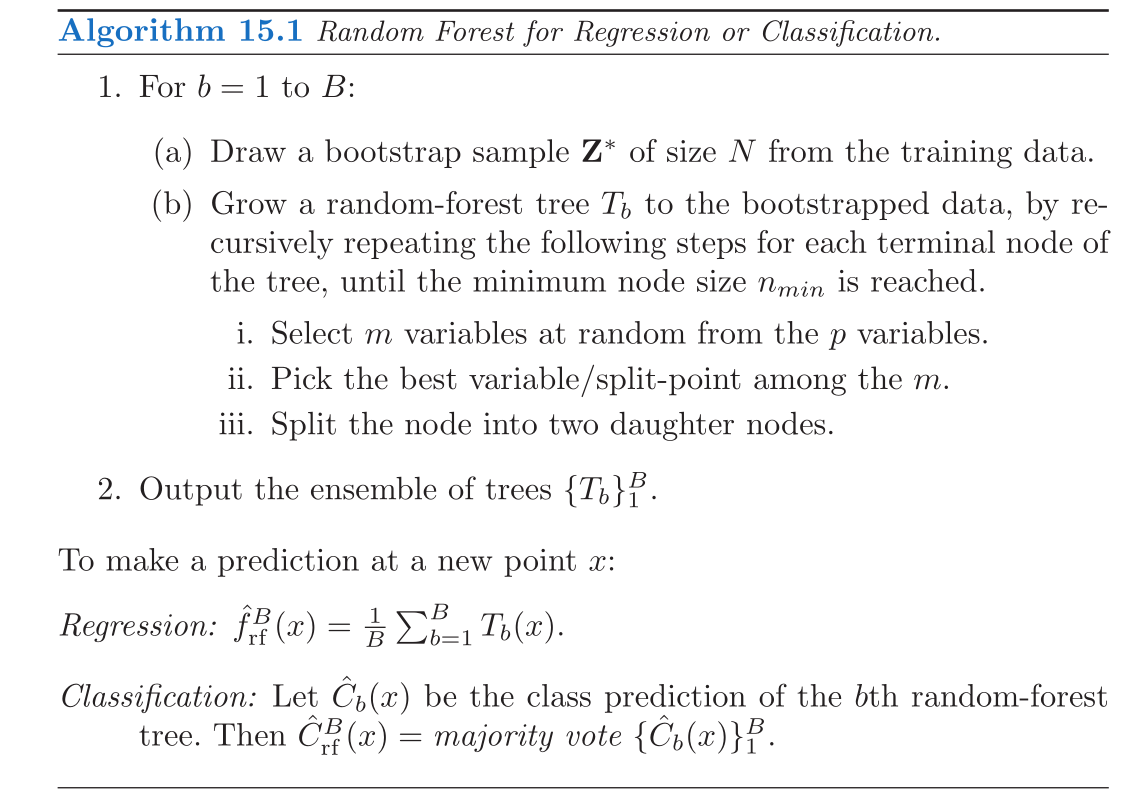

In [ ]:
np.random.seed(43)

n = 250

mu1 = np.array([0.0,0])
mu2 = np.array([1.0,0])
sigma1 = 5.0 * np.diag(np.array([1.0, 1.0]))
sigma2 = 0.5 * np.diag(np.array([1.0, 1.0]))

x1 = np.random.multivariate_normal(mu1, sigma1, n)
x2 = np.random.multivariate_normal(mu2, sigma2, n)
x = np.vstack([x1, x2])
y = np.concatenate([np.full(x1.shape[0], 0), np.full(x2.shape[0], 1)])

plt.figure()
plt.scatter(*x1.T,s=2.5)
plt.scatter(*x2.T,s=2.5)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

x_grid = np.linspace(np.min(x), np.max(x), 2000)
xx, yy = np.meshgrid(x_grid, x_grid)
xx_test = np.stack((xx,yy), axis=-1).reshape(-1, 2)

c = RandomForestClassifier(random_state=0, max_depth=15)

c.fit(x_train, y_train)
pred = c.predict(xx_test).reshape(xx.shape)

x1_train = x_train[y_train == 0]
x2_train = x_train[y_train == 1]

plt.figure()
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.contourf(xx, yy, pred, cmap="pink_r")
plt.scatter(*x1_train.T,s=2.5)
plt.scatter(*x2_train.T,s=2.5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_depths = np.arange(1, 2 * np.log2(n))

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

scores = []
for max_depth in max_depths:
    c = RandomForestClassifier(max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring, return_train_score=True)
    scores.append(s)

In [ ]:
scores = flat_dict(scores)

In [ ]:
plt.plot(max_depths, scores['train_accuracy'].mean(axis=1), '-*', label="train accuracy")
plt.plot(max_depths, scores['test_accuracy'].mean(axis=1), '-*', label="test accuracy")
plt.xlabel("Tree max depth")
plt.ylabel("Accuracy")
_ = plt.legend()

In [ ]:
import sklearn.metrics

def evaluate(c, x, y):
    y_pred = c.predict(x)
    if getattr(c, "decision_function", None):
        scores = c.decision_function(x)
    else:
        scores = c.predict_proba(x)[:,1]

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, y_pred, labels=['h', 'g']).ravel()
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)
    f1 = 2 * precision * recall / (precision + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("F1                        = {:.4f}".format(f1))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))
    print("Specificity (TNR, 1-FPR)  = {:.4f}".format(specificity))

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y.reshape(-1) == 'h'], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y.reshape(-1) == 'g'], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    tpr, fpr, _ = sklearn.metrics.roc_curve(y, scores, pos_label='g')
    auc = sklearn.metrics.roc_auc_score(y, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

c = RandomForestClassifier(random_state=0)

c.fit(x_train, y_train.reshape(-1))

train_acc = c.score(x_train, y_train) # accuracy
test_acc = c.score(x_test, y_test)

evaluate(c, x_test, y_test)

In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scoring = {
    "auc":       "roc_auc",
    "accuracy":  "accuracy",
}

max_depths = np.arange(4, 2*np.log2(x.shape[0]), 2)

scores = []
for max_depth in tqdm(max_depths):
    c = RandomForestClassifier(random_state=0, max_depth=max_depth)
    s = cross_validate(c, x, y.reshape(-1), cv=5, scoring=scoring)
    scores.append(s)

In [ ]:
scores = flat_dict(scores)

np.set_printoptions(precision=4)
print("fit time = {}".format(scores['fit_time'].mean(axis=1)))
for s in scoring.keys():
    print("{} = {}".format(s, scores["test_{}".format(s)].mean(axis=1)))

In [ ]:
plt.plot(max_depths, scores['test_auc'].mean(axis=1),'-*')
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC")

Изолирующий лес
-----------------------------

In [ ]:
import numpy as np
import pandas as pd

wl = np.asarray([7.8636, 8.0485, 8.2286, 8.4043, 8.5758, 8.7436, 8.9078, 9.0686, 9.2262, 9.3809, 9.5328, 9.6820, 9.8286, 9.9728, 10.1148, 10.2545, 10.3922, 10.5279, 10.6616, 10.7935, 10.9237, 11.0521, 11.1790, 11.3042, 11.4280, 11.5503, 11.6711, 11.7907, 11.9089, 12.0258, 12.1415, 12.2560, 12.3693, 12.4816, 12.5927, 12.7028, 12.8118, 12.9199, 13.0269, 13.1330, 13.2382, 13.3425, 13.4459, 13.5485, 10.9929, 11.3704, 11.7357, 12.0899, 12.4339, 12.7687, 13.0948, 13.4131, 13.7239, 14.0278, 14.3252, 14.6166, 14.9022, 15.1825, 15.4576, 15.7280, 15.9937, 16.2551, 16.5123, 16.7656, 17.0151, 17.2610, 17.5034, 17.7425, 17.9784, 18.2113, 18.4412, 18.6682, 18.8925, 19.1142, 19.3334, 19.5500, 19.7643, 19.9763, 20.1861, 20.3937, 20.5992, 20.8026, 21.0041, 21.2037, 21.4014, 21.5973, 21.7914, 21.9838, 22.1745, 22.3636, 22.5511, 22.7371, 22.9216])
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/lrs.csv', header=None)

x = np.asarray(data.iloc[:, 11:54])
wl = wl[:x.shape[1]]

In [ ]:
data.info()

In [ ]:
plt.plot(wl, x[0,:], "-")
plt.title("IRAS/LRS spectra")
plt.ylabel("Intensity (units)")
plt.xlabel("Wavelength (um)")

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
z = pca.fit_transform(x)

c = IsolationForest(n_estimators=1000, contamination="auto")
c.fit(z)

pred = c.predict(z)

In [ ]:
_ = plt.scatter(*z.T, s=2.5, c=pred, cmap="coolwarm")

In [ ]:
plt.figure()
plt.plot(wl, pca.components_[0,:], "-")
plt.plot(wl, pca.components_[1,:], "-")
plt.title("IRAS/LRS spectra")
plt.ylabel("Intensity (units)")
_ = plt.xlabel("Wavelength (um)")

In [ ]:
pca = PCA(n_components=10, random_state=42)
z = pca.fit_transform(x)

c = IsolationForest(n_estimators=1000, contamination="auto")
c.fit(z)

pred = c.score_samples(z)
outliers = data.iloc[np.argsort(pred)[0:10]]

plt.figure()
plt.plot(wl, outliers.iloc[0, 11:54], "-")
plt.title("IRAS/LRS spectra")
plt.ylabel("Intensity (units)")
_ = plt.xlabel("Wavelength (um)")

## Практические рекомендации

Скорее всего, вы будете работать с одним из следующих пакетов (библиотек):

*   https://lightgbm.readthedocs.io/en/latest/
*   https://xgboost.readthedocs.io/en/latest/
*   https://catboost.ai/- разработан в Яндексе, создатели утверждают, что он лучше других учитывает категориальные признаки.


Эти библиотеки позволяют:

* Усовершенственный градиентный бустинг для ускорения сходимости и уменьшения переобучения:
* Стохастический градиентный бустинг: выполнение разбиения на подвыборках признаков и/или строк
* Оптимизации для более быстрого нахождения наилучшего разбиения (например, [приближенный поиск с использованием квантилей в XGBoost](https://towardsdatascience.com/why-xgboost-is-so-effective-3a193951e289)).
* Очень эффективные реализации - быстрое обучение!
* Распараллеливание и вычисления на GPU.
* Интерфейсы для настройки параметров, CV и многого другого.

### LightGBM

In [ ]:
!pip -q install lightgbm

In [ ]:
from lightgbm import LGBMRegressor # sklearn-like API, but it's not the only one available
import lightgbm as lgb

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('https://raw.githubusercontent.com/hse-ppmm/Seminars/main/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
model = LGBMRegressor()
model.fit(x_train, y_train)

def r2_score(y_pred, y_true):
  return 1 - (np.var(y_pred) / np.var(y_true))

print(f'Test R^2 score: {r2_score(model.predict(x_test), y_test):.5f}')

Настройка

`learning_rate` is the multiplier for each subsequent tree.
`n_estimators` aka num_iterations.
`early_stopping_round` - stop training if score does not improve on a validation set for this many iterations.

In general you should first fix `n_estimators` to some value and then optimize other parameters.
`n_estimators` and `learning_rate` are very tightly related!

In [ ]:
n_estimator_values = np.linspace(10, 100, 15)
learning_rate_values = [0.2, 0.1, 0.05]

test_scores = {}
for learning_rate in learning_rate_values:
    for n_estimators in n_estimator_values:
        model =  LGBMRegressor(n_estimators=int(n_estimators), learning_rate=learning_rate, n_jobs=-1)
        model.fit(x_train, y_train)

        test_score = r2_score(model.predict(x_test), y_test)
        if not test_scores.get(learning_rate):
            test_scores[learning_rate] = []
        test_scores[learning_rate].append(test_score)

plt.figure()
for learning_rate in learning_rate_values:
    plt.plot(n_estimator_values, test_scores[learning_rate], label=f'Test score, LR: {learning_rate}')
plt.xlabel('n_estimators')
plt.ylabel('$R^2$ score')
plt.legend()
plt.title('GBM: the relationship between LR and n_estimators')
plt.ylim(0, 1)
plt.show()

A lot more info [here](https://dyakonov.org/2017/06/09/%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9-%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3/).

Important hack: boosting predictions can be out of bounds of training range!

In [ ]:
train_X = x_train.copy()
train_Y = y_train.copy()
test_X = x_test.copy()
test_Y = y_test.copy()

In [ ]:
model = LGBMRegressor(n_jobs=-1, learning_rate=0.1, num_round=100)
model.fit(train_X, train_Y)

predictions = model.predict(test_X)

plt.figure()
plt.title('Boosting results can be weird')
plt.scatter(test_Y, predictions)
plt.xlabel('test y')
plt.ylabel('predicted y')
plt.show()

In [ ]:
predictions[predictions > 5][:10]

In [ ]:
np.clip(predictions, 0, 5)[predictions > 5][:10]

In [ ]:
print(f'RMSE: {rmse(predictions, test_Y):.4f}')
print(f'RMSE after clipping: {rmse(np.clip(predictions, 0, 5), test_Y):.4f}')

print(f'R^2: {r2_score(predictions, test_Y):.4f}')
print(f'R^2 after clipping: {r2_score(np.clip(predictions, 0, 5), test_Y):.4f}')

#### Feature importance

In [ ]:
tmp = lgb.plot_importance(bst);

### Задание. Настройка GBM

Настройте гиперпараметры для LightGBM. Получите по крайней мере 0.9 по метрике $R^2$ на этом наборе данных.

[Идеи почерпните в документации к библиотеке](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

**Первый шаг:** создайте валидационный набор и попробуйте установить `early_stopping_round`, [инструкции см. здесь](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#early-stopping).

**Второй шаг:** определите, есть ли у вас проблемы с переобучением (посмотрите соответствующие графики), попробуйте некоторые [методы регуляризации] (https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html).

In [ ]:
## Добавьте Ваш код здесь

# validation_data = lgb.Dataset() # Create validation set here
# train_data = lgb.Dataset()

# params = {
#     'n_jobs': -1,
#     'learning_rate': 0.2,
#     #'early_stopping_round': None, # Set to some value
# }

# num_round = 1000
# model = lgb.train(params, train_data,  num_round, valid_sets=[validation_data])

In [ ]:
# predictions = model.predict(test_X)

In [ ]:
# print(f'Test R^2 score: {r2_score(predictions, test_Y):.4f}')
# print(f'Test RMSE: {rmse(predictions, test_Y):.4f}')

### (Дополнительно) Алгоритм RuleFit Фридмана и Попеску.

Идея заключается в увеличении ансамбля деревьев путем построения набора правил из каждого дерева в коллекции.


1. Сначала мы строим **ансамбль деревьев** $\mathbf{T}=\{ T_m\}$. Для этого мы можем использовать алгоритмы Random Forest или GBM.

2. Затем, **для каждого дерева** $T_m$, мы строим его **мини-совокупность
правил** $\mathbf{T}^m_{RULE}$, где каждое правило - это умножение индикаторных функций. В приведенном ниже примере:
  - $\mathbf{T}^m_{RULE} = \{ r_1(x), r_2(x), r_3(x), r_4(x)\}$.
  - $r_3(x) = \mathbb{I} \{ x_2 < 3 \} \times \mathbb{I} \{ x_3 < 7 \}$.

Пример из https://christophm.github.io/interpretable-ml-book/rulefit.html:
![](https://christophm.github.io/interpretable-ml-book/images/rulefit.jpg)


3. Затем мы объединяем эти правила, чтобы сформировать **большой ансамбль правил**:
$$ \mathbf{T}_{RULE} = \cup_{m=1}^M \mathbf{T}^m_{RULE}$$

4. И, наконец, этот набор правил рассматривается как любой другой ансамбль и обрабатывается с помощью лассо или аналогичной регуляризированной регрессии.

Существует **несколько преимуществ** такого подхода:
- Расширяется пространство моделей, что может привести к улучшению производительности.
- Правила легче интерпретировать, чем деревья, поэтому существует потенциал для упрощения модели.
- Часто естественно дополнить $\mathbf{T}_{RULE}$, включив каждую переменную $X_j$ отдельно, что позволяет ансамблю хорошо моделировать линейные функции.

См. также:
- Оригинальная статья: http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf
- Хорошее объяснение с формулами: https://christophm.github.io/interpretable-ml-book/rulefit.html
- Библиотека Python: https://github.com/christophM/rulefit
- Реализация H2O (как на Python, так и на R): https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/rulefit.html

In [ ]:
!pip install git+https://github.com/christophM/rulefit.git

In [ ]:
import numpy as np
import pandas as pd

from rulefit import RuleFit

boston_data = pd.read_csv("https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv", index_col=0)

y = boston_data.medv.values
X = boston_data.drop("medv", axis=1)
features = X.columns
X = X.values

rf = RuleFit()
rf.fit(X, y, feature_names=features)

In [ ]:
boston_data.head()

In [ ]:
rf.predict(X)

In [ ]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(rules)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
cal_housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2,
                                                    random_state=1)